In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt

#Show sample images 
from keras.preprocessing import image                  
from keras.preprocessing.image import img_to_array, load_img
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 


sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

C:\Users\Sudarshan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:


# define function to load train and test datasets 
# the function returns 3 numpy arrays with filenames, one-hot-encoded values and raw outputs
def load_dataset(path):
    data = load_files(path)
    alphabet_files = np.array(data['filenames'])
    targets = np.array(data['target'])
    alphabet_targets = np_utils.to_categorical(targets, 50)
    
    return alphabet_files, alphabet_targets, targets

# load train and test datasets
train_files, train_targets, raw_train_targets = load_dataset('CMATERdb_3.1.2/Train')
test_files, test_targets, raw_test_targets = load_dataset('CMATERdb_3.1.2/Test')

# load list of characters
alphabets = [item[25:-1] for item in sorted(glob("CMATERdb_3.1.2/Train/*/"))]

# print statistics about the dataset
print('There are %d total alphabets' % len(alphabets))
print('There are %s total alphabet images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training alphabet images.' % len(train_files))
print('There are %d test alphabet images.'% len(test_files))


There are 50 total alphabets
There are 15000 total alphabet images.

There are 12000 training alphabet images.
There are 3000 test alphabet images.


Distribution of the training data in the dataset


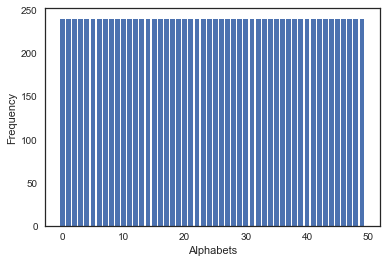

Distribution of the test data in the dataset


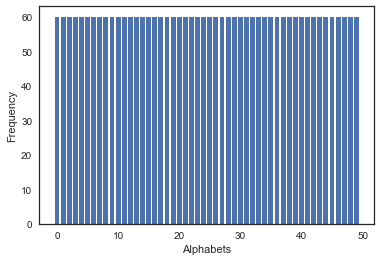

In [4]:
# Function to display the distribution of data in the training and test sets by alphabet classes
def plot_dist(target_set):
    plt.figure(figsize=(6,4))
    labels, values = zip(*target_set.items())
    #indexes = np.arange(len(labels))
    width = 0.8
    plt.bar(labels, values, width)
    plt.xlabel('Alphabets')
    plt.ylabel('Frequency')
    plt.show()

print('Distribution of the training data in the dataset')    
plot_dist(Counter(raw_train_targets))
print('Distribution of the test data in the dataset') 
plot_dist(Counter(raw_test_targets))

C:\Users\Sudarshan\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


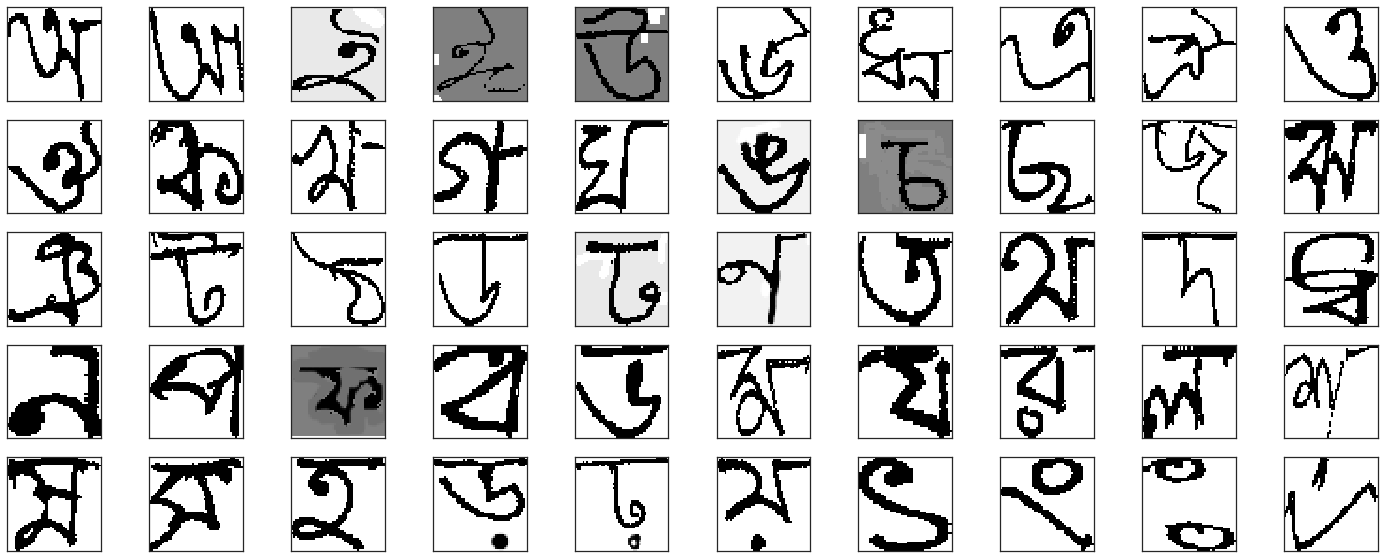

In [5]:


#Scan through the training dataset to pick up one random character each folder
alphabet_folders = sorted(glob("CMATERdb_3.1.2/Train/*/"))
sample_files = []
for folder in alphabet_folders:
    sample_files.append(glob(folder + "*.bmp")[np.random.randint(0,49)])
sample_files = np.array(sample_files)

#Display the characters
fig = plt.figure(figsize=(25,10))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(load_img(sample_files[i], target_size=(50,50), grayscale=True)), cmap = 'gray')
    ax.set_title("{}".format(alphabets[i]),
                 color="green")

C:\Users\Sudarshan\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


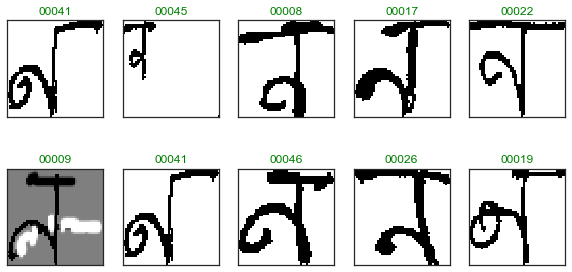

In [6]:
#View random characters in folders
sample_files = []
folder = 'CMATERdb_3.1.2/Train/202/'
for i in range(10):    
    sample_files.append(glob(folder + "*.bmp")[np.random.randint(0, 49)])

sample_files = np.array(sample_files)

fig = plt.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(load_img(sample_files[i], target_size=(50,50), grayscale=True)), cmap = 'gray')
    ax.set_title("{}".format(sample_files[i][29:-4]),
                 color="green")

There are 50 total alphabets
There are 15000 total alphabet images.

There are 9600 training alphabet images.
There are 2400 validation alphabet images.
There are 3000 test alphabet images.

Distribution of the validation data in the dataset


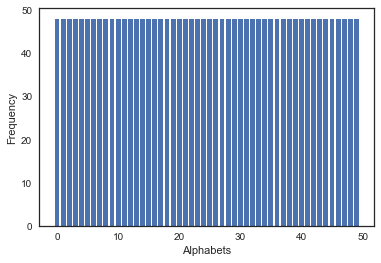

In [7]:

train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets, test_size = 0.2,  stratify = raw_train_targets)

# print statistics about the dataset post split
print('There are %d total alphabets' % len(alphabets))
print('There are %s total alphabet images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training alphabet images.' % len(train_files))
print('There are %d validation alphabet images.' % len(valid_files))
print('There are %d test alphabet images.\n'% len(test_files))

# Show distribution of data in validation set
raw_valid_targets = []
for i in range(len(valid_targets)):
    raw_valid_targets.append(np.argmax(valid_targets[i]))
    
raw_valid_targets = np.array(raw_valid_targets)
print('Distribution of the validation data in the dataset')  
plot_dist(Counter(raw_valid_targets))

In [8]:
### Prepare the Training, Validation and Test Datasets
def path_to_tensor(img_path):
    if 'bcc000060.db' not in img_path:
        # loads RGB image as PIL.Image.Image type
        img = load_img(img_path, target_size=(64, 64), grayscale=False)
        # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
        x = img_to_array(img)
        # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
        return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

# pre-process the data for Keras. We rescale the images by dividing every pixel in every image by 255. 
# So the scale is now 0-1 instead of 0-255.
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

# print number of training, validation, and test images
print(train_tensors.shape[0], 'train samples')
print(valid_tensors.shape[0], 'valid samples')
print(test_tensors.shape[0], 'test samples')

9600 train samples
2400 valid samples
3000 test samples




```
Test F1 accuracy: 97.7000%
Total error: 69

more conv layer
```



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2368      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        9232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        51264     
__________


Epoch 00066: val_loss did not improve from 0.12086
Epoch 67/200
75/75 [==============================] - 8s 103ms/step - loss: 0.0904 - acc: 0.9710 - val_loss: 0.1307 - val_acc: 0.9670

Epoch 00067: val_loss did not improve from 0.12086
Epoch 68/200
75/75 [==============================] - 7s 99ms/step - loss: 0.0885 - acc: 0.9729 - val_loss: 0.1530 - val_acc: 0.9577

Epoch 00068: val_loss did not improve from 0.12086
Epoch 69/200
75/75 [==============================] - 7s 99ms/step - loss: 0.0847 - acc: 0.9764 - val_loss: 0.1626 - val_acc: 0.9599

Epoch 00069: val_loss did not improve from 0.12086
Epoch 70/200
75/75 [==============================] - 8s 104ms/step - loss: 0.0901 - acc: 0.9701 - val_loss: 0.1401 - val_acc: 0.9595

Epoch 00070: val_loss did not improve from 0.12086
Epoch 71/200
75/75 [==============================] - 7s 100ms/step - loss: 0.0913 - acc: 0.9723 - val_loss: 0.1685 - val_acc: 0.9577

Epoch 00071: val_loss did not improve from 0.12086
Epoch 72/200
75/75 [

75/75 [==============================] - 8s 105ms/step - loss: 0.0803 - acc: 0.9757 - val_loss: 0.1527 - val_acc: 0.9538

Epoch 00110: val_loss did not improve from 0.11444
Epoch 111/200
75/75 [==============================] - 8s 102ms/step - loss: 0.0867 - acc: 0.9732 - val_loss: 0.1553 - val_acc: 0.9630

Epoch 00111: val_loss did not improve from 0.11444
Epoch 112/200
75/75 [==============================] - 7s 100ms/step - loss: 0.0780 - acc: 0.9756 - val_loss: 0.1602 - val_acc: 0.9569

Epoch 00112: val_loss did not improve from 0.11444
Epoch 113/200
75/75 [==============================] - 8s 102ms/step - loss: 0.0842 - acc: 0.9746 - val_loss: 0.1313 - val_acc: 0.9595

Epoch 00113: val_loss did not improve from 0.11444
Epoch 114/200
75/75 [==============================] - 7s 99ms/step - loss: 0.0806 - acc: 0.9742 - val_loss: 0.1718 - val_acc: 0.9586

Epoch 00114: val_loss did not improve from 0.11444
Epoch 115/200
75/75 [==============================] - 8s 100ms/step - loss: 0.0

75/75 [==============================] - 8s 112ms/step - loss: 0.0756 - acc: 0.9762 - val_loss: 0.1622 - val_acc: 0.9617

Epoch 00154: val_loss did not improve from 0.11444
Epoch 155/200
75/75 [==============================] - 8s 106ms/step - loss: 0.0745 - acc: 0.9773 - val_loss: 0.1785 - val_acc: 0.9525

Epoch 00155: val_loss did not improve from 0.11444
Epoch 156/200
75/75 [==============================] - 8s 105ms/step - loss: 0.0790 - acc: 0.9769 - val_loss: 0.1264 - val_acc: 0.9657

Epoch 00156: val_loss did not improve from 0.11444
Epoch 157/200
75/75 [==============================] - 8s 104ms/step - loss: 0.0702 - acc: 0.9784 - val_loss: 0.1219 - val_acc: 0.9652

Epoch 00157: val_loss did not improve from 0.11444
Epoch 158/200
75/75 [==============================] - 8s 105ms/step - loss: 0.0817 - acc: 0.9760 - val_loss: 0.1348 - val_acc: 0.9652

Epoch 00158: val_loss did not improve from 0.11444
Epoch 159/200
75/75 [==============================] - 8s 102ms/step - loss: 0.


Epoch 00197: val_loss did not improve from 0.11016
Epoch 198/200
75/75 [==============================] - 7s 99ms/step - loss: 0.0673 - acc: 0.9782 - val_loss: 0.1443 - val_acc: 0.9661

Epoch 00198: val_loss did not improve from 0.11016
Epoch 199/200
75/75 [==============================] - 7s 99ms/step - loss: 0.0725 - acc: 0.9768 - val_loss: 0.1437 - val_acc: 0.9608

Epoch 00199: val_loss did not improve from 0.11016
Epoch 200/200
75/75 [==============================] - 7s 97ms/step - loss: 0.0671 - acc: 0.9791 - val_loss: 0.1360 - val_acc: 0.9648

Epoch 00200: val_loss did not improve from 0.11016
Test F1 accuracy: 98.4333%
Test F1 accuracy: 0.9843%
Total error: 47


C:\Users\Sudarshan\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


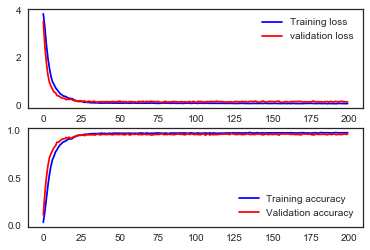

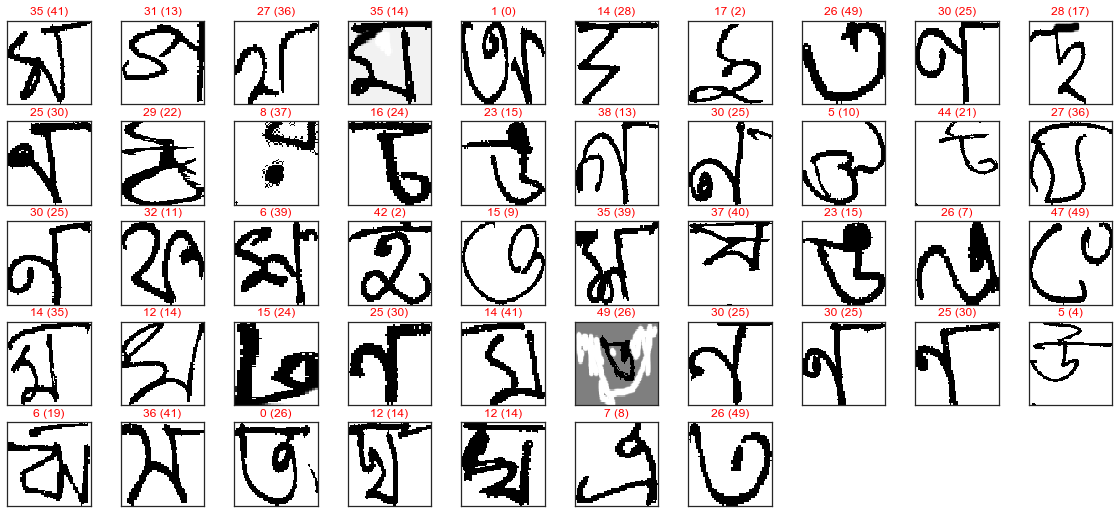

In [9]:
model_ = Sequential()
model_.add(Conv2D(filters = 16, kernel_size = (7,7), padding = 'Same', activation='relu', input_shape = (train_tensors.shape[1:])))
model_.add(Conv2D(filters = 16, kernel_size = (6,6), padding = 'Same', activation='relu'))
model_.add(MaxPooling2D(pool_size = (2,2)))
#model_.add(Dropout(0.2))

model_.add(Conv2D(filters = 32, kernel_size = (6,6), padding = 'Same', activation='relu'))
model_.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
model_.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))


model_.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'Same', activation='relu'))
model_.add(Conv2D(filters = 128, kernel_size = (4,4), padding = 'Same', activation = 'relu'))
model_.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
#model_.add(Dropout(0.3))

model_.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same', activation = 'relu'))

model_.add(Flatten())
model_.add(Dense(256, activation='relu'))
model_.add(Dropout(0.54))

model_.add(Dense(50, activation = 'sigmoid'))

print(model_.summary())


from keras.optimizers import adam
from keras.callbacks import ReduceLROnPlateau

optimizer_ = adam(lr = 0.001, epsilon = 1e-08, decay = 0.0)
model_.compile(optimizer = optimizer_, loss = 'categorical_crossentropy', metrics = ['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                           patience = 2,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 0.00001)
epochs = 200
batch_size = 128


# Augment the training data 
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=15, 
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest') # randomly rotate images by 15 degrees

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=15, 
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='weights.best.with_augmentation_new.hdf5', verbose=1, 
                               save_best_only=True)


history = model_.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                                steps_per_epoch=train_tensors.shape[0] // batch_size,
                                epochs=epochs, 
                                verbose=1, 
                                callbacks=[checkpointer, learning_rate_reduction],
                                validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                                validation_steps=valid_tensors.shape[0] // batch_size)


# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#load the model with best weights
model_.load_weights('weights.best.with_augmentation_new.hdf5')
#model.load_weights('saved_models/weights.best.with_augmentation.hdf5')
# get index of predicted alphabetnfor each image in test set
alphabet_predictions = [np.argmax(model_.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

from sklearn import metrics
y_true = [np.argmax(y_test) for y_test in test_targets]
f1_accuracy = 100* metrics.f1_score(y_true,alphabet_predictions, average = 'micro')
print('Test F1 accuracy: %.4f%%' % f1_accuracy)

print('Test F1 accuracy: %.4f%%' % metrics.accuracy_score(y_true, alphabet_predictions))

#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_true, alphabet_predictions)

### Error Analysis
## Find all the test cases where the prediction does not match the actual.
## Trace back to file names and analyse 
## Loop over test tensors, predict and if doesnt match with actual add the file
## name to an array

error_files = []
error_images = []
for i, idx in enumerate(np.random.choice(test_tensors.shape[0], size=3000, replace=False)):
    pred_idx = alphabet_predictions[idx]
    true_idx = np.argmax(test_targets[idx])
    if pred_idx != true_idx:
        error_files.append(test_files[idx])
        error_images.append(idx)

print("Total error: "+ str(len(error_files)))
error_files = np.array(error_files) 

error_images = np.array(error_images) 
errors=np.stack((error_images,error_files),axis=-1)
         

fig = plt.figure(figsize=(20,20))
i = 0 
for idx, pic in errors:
    idx = int(idx)
    ax = fig.add_subplot(11, 10, i + 1, xticks=[], yticks=[])
    
    #print ('Misclassified the file: ' + pic + ' As: ' + str (alphabet_predictions[idx] ) + ' instead of ' + str(np.argmax(test_targets[idx])) + ' Index: ' + str(idx))

    ax.imshow(np.squeeze(load_img(pic, target_size=(100,100), grayscale=True)), cmap = 'gray')
    ax.set_title("{} ({})".format(str (alphabet_predictions[idx] ), str(np.argmax(test_targets[idx]))),
                 color=("red"))
    i += 1
    
    


In [10]:
f1_accuracy = 100* metrics.f1_score(y_true,alphabet_predictions, average = 'micro')
print('Test F1 accuracy: %.4f%%' % f1_accuracy)

print('Test accuracy: %.4f%%' % metrics.accuracy_score(y_true, alphabet_predictions))

Test F1 accuracy: 98.4333%
Test accuracy: 0.9843%


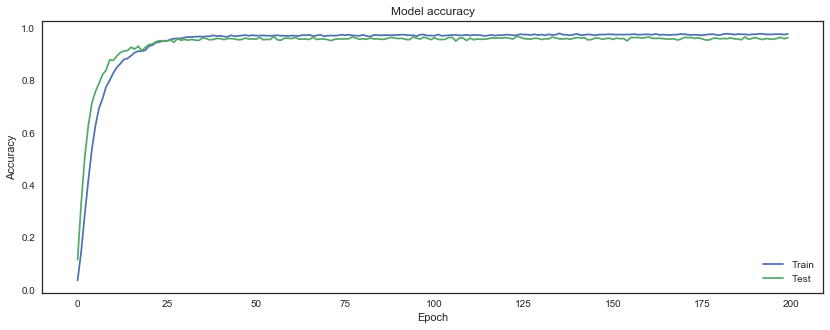

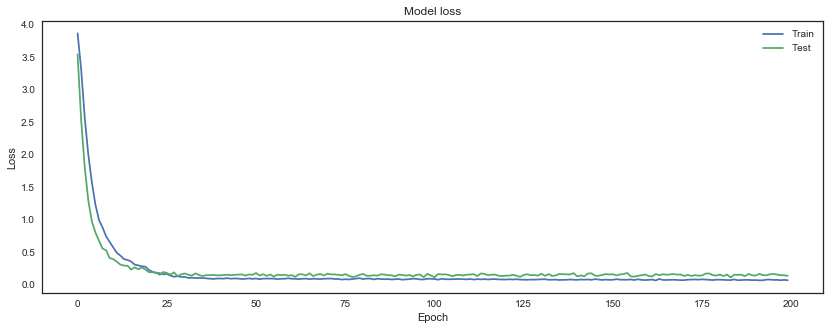

In [13]:
# Plot training & validation accuracy values

fig = plt.figure(figsize=(14, 5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values

fig = plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [14]:
# evaluate and print test accuracy
score = model_.evaluate(test_tensors, test_targets, verbose=1)
print('\n', 'Test accuracy:', score[1])

3000/3000 [==============================] - 1s 174us/step

 Test accuracy: 0.9843333333333333
